In [2]:
import numpy as np
import h5py
import math
from sklearn.decomposition import PCA
from pca import pca
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import peakutils
import os, sys
from BaselineRemoval import BaselineRemoval
from sklearn.cluster import DBSCAN
import scipy
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [3]:
class HiddenPrints:
	def __enter__(self):
		self._original_stdout = sys.stdout
		sys.stdout = open(os.devnull, 'w')

In [4]:
def __exit__(self, exc_type, exc_val, exc_tb):
	sys.stdout.close()
	sys.stdout = self._original_stdout

In [5]:
def remove_outliers(xset, yset, zset, eset, threshold):
	"""
	Uses DBSCAN to find and remove outliers in 3D data
	"""
	data = np.array([xset.T, yset.T, zset.T]).T
	DBSCAN_cluster = DBSCAN(eps=7, min_samples=10).fit(data)
	out_of_cluster_index = np.where(DBSCAN_cluster.labels_==-1)
	del data
	rev = out_of_cluster_index[0][::-1]
	#if len(out_of_cluster_index[0]) > 0:
	for i in rev:
		xset = np.delete(xset, i)
		yset = np.delete(yset, i)
		zset = np.delete(zset, i)
		eset = np.delete(eset, i)
	#if len(xset) <= threshold:
	#	veto = True
	#else:
    #veto = False
	return xset, yset, zset, eset, False

In [6]:
print('Veto on Length @ 70 mm')
print('Veto on Integrated Charge @ 800k')
def track_len(xset, yset, zset):
    """
    Uses PCA to find the length of a track
    """
    veto_on_length = False
 
    # Form data matrix
    data = np.concatenate((xset[:, np.newaxis], 
                           yset[:, np.newaxis], 
                           zset[:, np.newaxis]), 
                           axis=1)

    # Use PCA to find track length
    pca = PCA(n_components=3)
    principalComponents = pca.fit(data)
    principalComponents = pca.transform(data)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
    
    track_len = 2.35*principalDf.std()[0]
    track_width = 2.35*principalDf.std()[1]
    track_depth = 2.35*principalDf.std()[2]
    #if track_len > 70:
    #    veto_on_length = True
    
    return track_len, veto_on_length, track_width, track_depth

Veto on Length @ 70 mm
Veto on Integrated Charge @ 800k


In [7]:
def main(h5file, threshold):
    """
    This functions does the following: 
    - Converts h5 files into ndarrays. 
    - Removes outliers.
    - Calls PCA to return track length.
    - Sums mesh signal to return energy.
    """
    # Converts h5 files into ndarrays, and output each event dataset as a separte list
    num_events = int(len(list(h5file.keys()))/2) 
    
    len_list = []
    width_list = []
    depth_list = []
    good_events = []
    tot_energy = []
    tracemax_list = []
    tracedev_list = []
    pads_list = []
    
    skipped_events = 0
    veto_events = 0
    
    pbar = tqdm(total=num_events+1)
    for i in range(0, num_events):
        str_event = f"Event_[{i}]"
        
        # Apply pad threshold
        event = np.array(h5file[str_event][:])
        if len(event) <= threshold:
            skipped_events += 1
            pbar.update(n=1)
            continue
            
        # Make copy of datasets
        dset_0_copyx = event['x']
        dset_0_copyy = event['y'] 
        dset_0_copyz = event['z'] - min(event['z'])
        dset_0_copye = event['A']

        
        # Apply veto condition
        R = 36                           # Radius of the pad plane
        r = np.sqrt(dset_0_copyx**2 + dset_0_copyy**2)
        statements = np.greater(r, R)    # Check if any point lies outside of R
      
        if np.any(statements) == True:
            veto_events += 1
            pbar.update(n=1)
            continue
        
        
        # Call remove_outliers to get dataset w/ outliers removed
        dset_0_copyx, dset_0_copyy, dset_0_copyz, dset_0_copye, veto = remove_outliers(dset_0_copyx, dset_0_copyy, dset_0_copyz, dset_0_copye, threshold)
        if veto == True:
            skipped_events += 1
            pbar.update(n=1)
            continue

        
        # Call track_len() to create lists of all track lengths
        length, veto_on_length, width, depth = track_len(dset_0_copyx, dset_0_copyy, dset_0_copyz)
        if veto_on_length == True:
            veto_events += 1
            pbar.update(n=1)
            continue 

        
       	str_trace = f"Trace_[{i}]"
        trace = np.array(h5file[str_trace][:])
        max_val = np.argmax(trace)
        low_bound = max_val - 75
        if low_bound < 0:
            low_bound = 5
        upper_bound = max_val + 75
        if upper_bound > 511:
            upper_bound = 506
        trace = trace[low_bound:upper_bound]

        polynomial_degree=2 
        baseObj=BaselineRemoval(trace)
        trace=baseObj.IModPoly(polynomial_degree)

        #if np.sum(trace) > 800000:
        #    veto_events += 1
        #    pbar.update(n=1)
        #    continue

        len_list.append(length)
        width_list.append(width)
        depth_list.append(depth)
        tot_energy.append(np.sum(trace))
        tracemax_list.append(np.max(trace))
        tracedev_list.append(np.std(trace))
        pads_list.append(len(trace[trace > 0]))

        # Track event number of good events
        good_events.append(i)  
        pbar.update(n=1)

    return (tot_energy, skipped_events, veto_events, good_events, len_list, width_list, depth_list, tracemax_list, tracedev_list, pads_list)

In [9]:
# assign directory
directory = "C:/Users/Adam/OneDrive - Tenundra, Inc/Shared with Everyone/simOutput/"

output_df = pd.DataFrame(columns=['file','event','length', 'width', 'depth', 'tracesum', 'tracemax', 'tracedev', 'padnum'])

file_names = []
# iterate over files in directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        if f[-3:] == '.h5':
            print(filename)
            file_names.append(filename)
            h5f = h5py.File(directory+filename, 'r')
            (tot_energy, skipped_events, veto_events, good_events, len_list, width_list, depth_list, tracemax_list, tracedev_list, pads_list) = main(h5file=h5f, threshold=15)
            for event in range(len(tot_energy)):
                output_df = output_df.append({'file' : filename, 
                                              'event' : event, 
                                              'length' : len_list[event], 
                                              'width' : width_list[event], 
                                              'depth' : depth_list[event], 
                                              'tracesum' : tot_energy[event], 
                                              'tracemax' : tracemax_list[event], 
                                              'tracedev' : tracedev_list[event], 
                                              'padnum' : pads_list[event]}
                                             ,ignore_index = True)


100pa.h5


 95%|█████████▌| 20/21 [00:01<00:00, 16.71it/s]


100x800p.h5


 95%|█████████▌| 20/21 [00:00<00:00, 21.84it/s]


2000p.h5


 95%|█████████▌| 20/21 [00:00<00:00, 20.48it/s]


200x800p.h5


 95%|█████████▌| 20/21 [00:01<00:00, 18.01it/s]


500a.h5


 95%|█████████▌| 20/21 [00:01<00:00, 18.72it/s]


In [10]:
for file in file_names:
    print(file)
    print('length')
    print(output_df[output_df['file'] == file]['length'].mean())
    print(output_df[output_df['file'] == file]['length'].std())
    print('width')
    print(output_df[output_df['file'] == file]['width'].mean())
    print(output_df[output_df['file'] == file]['width'].std())
    print('depth')
    print(output_df[output_df['file'] == file]['depth'].mean())
    print(output_df[output_df['file'] == file]['depth'].std())
    print('tracesum')
    print(output_df[output_df['file'] == file]['tracesum'].mean())
    print(output_df[output_df['file'] == file]['tracesum'].std())
    print('tracemax')
    print(output_df[output_df['file'] == file]['tracemax'].mean())
    print(output_df[output_df['file'] == file]['tracemax'].std())
    print('tracedev')
    print(output_df[output_df['file'] == file]['tracedev'].mean())
    print(output_df[output_df['file'] == file]['tracedev'].std())
    print('padnum')
    print(output_df[output_df['file'] == file]['padnum'].mean())
    print(output_df[output_df['file'] == file]['padnum'].std())
    print()

#plt.hist(output_df[output_df['file'] == '100x800p.h5']['width'])
#plt.hist(output_df[output_df['file'] == '500a.h5']['width'])

100pa.h5
length
13.663207083597806
0.4741704134343235
width
5.129438563951781
0.5953557388767861
depth
2.4896696420187556
0.7069245080364428
tracesum
87147.87219230608
277.31403839079707
tracemax
8045.338295684564
859.6548029003708
tracedev
1727.9481348005447
104.15447503226527
padnum
108.3
6.72857222674516

100x800p.h5
length
13.663207083597806
0.4741704134343235
width
5.129438563951781
0.5953557388767861
depth
2.4896696420187556
0.7069245080364428
tracesum
87147.87219230608
277.31403839079707
tracemax
8045.338295684564
859.6548029003708
tracedev
1727.9481348005447
104.15447503226527
padnum
108.3
6.72857222674516

2000p.h5
length
13.663207083597806
0.4741704134343235
width
5.129438563951781
0.5953557388767861
depth
2.4896696420187556
0.7069245080364428
tracesum
87147.87219230608
277.31403839079707
tracemax
8045.338295684564
859.6548029003708
tracedev
1727.9481348005447
104.15447503226527
padnum
108.3
6.72857222674516

200x800p.h5
length
13.663207083597806
0.4741704134343235
width
5.12

In [9]:
output_df.to_csv('particle_types_output.csv', index=False)

In [8]:
output_df

,file,event,length,width,depth,tracesum,tracemax,tracedev,padnum
0,100pa.h5,0,13.077098,5.567414,2.841951,87386.476322,7342.320943,1648.034900,105
1,100pa.h5,1,13.657350,4.794319,1.989027,87512.740455,8569.750454,1794.071003,114
2,100pa.h5,2,14.100402,4.807558,1.878645,86954.528939,7982.506538,1724.944423,113
3,100pa.h5,3,13.895312,5.524714,2.970167,86863.336680,7175.524555,1619.503887,100
4,100pa.h5,4,13.114119,4.629209,1.670077,87542.458244,9283.082248,1878.206076,113
...,...,...,...,...,...,...,...,...,...
95,500a.h5,15,13.007167,6.186873,3.184501,86905.507420,6864.992412,1579.389559,94
96,500a.h5,16,13.235621,5.210457,2.750258,86888.765114,8368.075384,1765.053985,114
97,500a.h5,17,14.107296,4.528007,2.162254,86812.378018,8924.576336,1829.581880,114
98,500a.h5,18,14.033838,5.457087,2.116121,87405.354382,7357.944648,1649.184471,100


In [34]:
# Load in parameters and add values to output
parameters = pd.read_csv('parameters.csv')
for i in output_df.index:
    sim = output_df.loc[i,'file'][:-3]
    paramrow = parameters[parameters['Sim'] == sim]
    for var in ['CoefL', 'CoefT', 'Gain', 'GETGain', 'PeakingTime', 'MaxRange']:
        output_df.loc[i,var]  = paramrow.loc[paramrow.index[0],var]

In [36]:
output_df.to_csv('output.csv', index=False)

In [7]:
output_df = pd.read_csv('output.csv')

Significant: ['CoefT0.h5', 'CoefT10.h5', 'Gain0.h5', 'Gain10.h5', 'GETGain0.h5', 'GETGain10.h5', 'PeakingTime0.h5']
Possible: ['CoefL0.h5', 'PeakingTime10.h5']
Insignificant: ['CoefL10.h5']
Indentical: ['MaxRange0.h5', 'MaxRange10.h5']

r²= 0.0014113745101854702
slope= [-1182.34869191]
intercept= 5.154429735169867


ValueError: The number of FixedLocator locations (11), usually from a call to set_ticks, does not match the number of ticklabels (12).

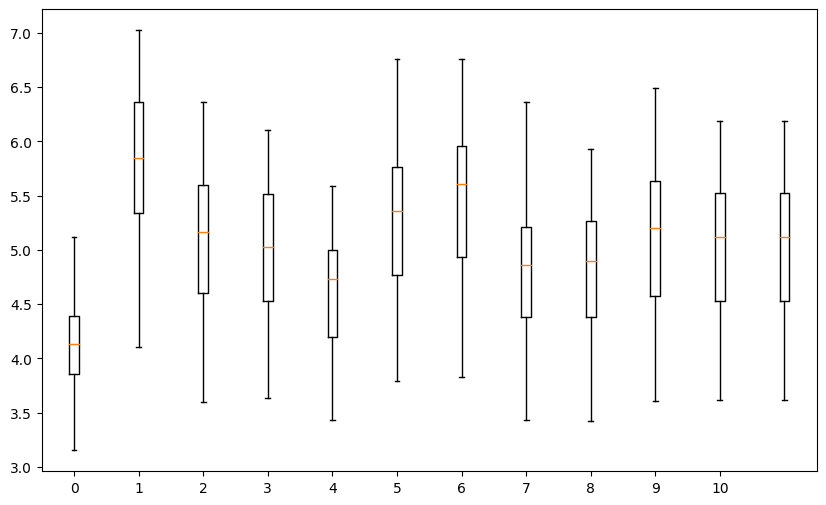

In [67]:
# Test statistics for specific variable
stat_df = pd.DataFrame(columns=['file','var','f','p','mean','median', 'std'])

fig, ax = plt.subplots()

param = 'CoefL'
var = 'width'
labels = []
ref_data = output_df[output_df['file'] == 'Reference.h5'][var]
full_data = [np.array(ref_data)]
#ax.boxplot(ref_data, positions=[1])

#interest_files = [param + str(i) + '.h5' for i in range(0,11)]
interest_files = ['CoefT0.h5', 'CoefT10.h5', 'CoefL0.h5', 'CoefL10.h5', 'Gain0.h5', 'Gain10.h5', 'GETGain0.h5', 'GETGain10.h5', 'PeakingTime0.h5', 'PeakingTime10.h5', 'MaxRange0.h5', 'MaxRange10.h5']
i = 0
for file in interest_files:
    data = output_df[output_df['file'] == file][var]
    f,p = scipy.stats.f_oneway(ref_data, data, axis=0)
    stat_df = stat_df.append({
        'file' : file, 'var' : var, 'f' : f, 'p' : p, 'mean' : np.average(data),
        'median' : np.median(data), 'std' : np.std(data)},ignore_index=True)
    ax.boxplot(data, positions=[i])
    labels.append(file)
    full_data.append(np.array(data))
    i += 1

# display statistics of data
stat_df.sort_values('p')
print('Significant:', list(stat_df[stat_df['p'] < 0.05]['file']))
print('Possible:', list(stat_df[(stat_df['p'] > 0.05) * (stat_df['p'] < 0.5)]['file']))
print('Insignificant:', list(stat_df[(stat_df['p'] > 0.5) * (stat_df['p'] < 1)]['file']))
print('Indentical:', list(stat_df[stat_df['p'] == 1]['file']))

# perform linear regression
x_data = np.array(output_df[output_df['file'].isin(interest_files)][param]).reshape(-1,1)
y_data = np.array(output_df[output_df['file'].isin(interest_files)][var])
model = LinearRegression().fit(x_data, y_data)
print('\nr²=', model.score(x_data, y_data))
print('slope=', model.coef_)
print('intercept=', model.intercept_)

# plot data
fig.set_size_inches(10,6)
ax.set_xticks(range(11), labels=labels, rotation='vertical');
ax.set_ylabel(var)

In [162]:
#tdf = output_df[output_df['file'].isin(['MaxRange'+str(i)+'.h5' for i in range(11)])]
#plt.plot(output_df[''])

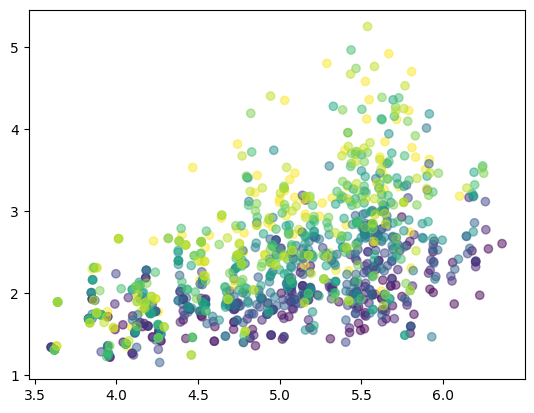

In [65]:
parameter = 'CoefL'
xvar = 'width'
yvar = 'depth'

plt.scatter(output_df[output_df['file'].isin([parameter+str(i)+'.h5' for i in range(11)])][xvar], output_df[output_df['file'].isin([parameter+str(i)+'.h5' for i in range(11)])][yvar], c=output_df[output_df['file'].isin([parameter+str(i)+'.h5' for i in range(11)])][parameter], cmap='viridis', alpha=0.5)

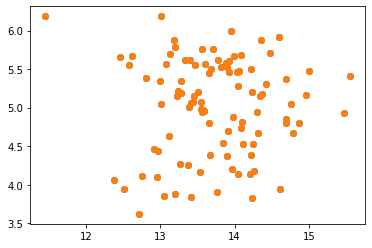

In [10]:
plt.scatter(output_df[output_df['file'] == 'Reference.h5']['length'], output_df[output_df['file'] == 'Reference.h5']['width'], label='Reference')
plt.scatter(output_df[output_df['file'] == 'CoefL5.h5']['length'], output_df[output_df['file'] == 'CoefL5.h5']['width'], label='MaxRange0')